In [21]:
import os
import argparse
import torch
import numpy as np
from models import build_model
from utils import get_dataset, backdoor_train, backdoor_evaluate, validation_per_class
from poisoned_dataset import create_backdoor_data_loader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [46]:
class args():
    dir = '/home/teun/internship/cluster/results'
    datanames = ['mnist', 'emnist', 'fmnist']
    seed = 1
    epsilon = 0.1
    source_label=0
    target_label=1
    epsilons=[0.001, 0.005, 0.010, 0.015, 0.020]
    iid = "True"

In [77]:
bool("False")

True

In [108]:
torch.manual_seed(args.seed)
np.random.seed(args.seed)
device = torch.device('cpu')

data_dir = '/home/teun/internship/sniper-backdoor/data'
results_dir = '/home/teun/internship/cluster/results'

epsilons = []
cads = []
asrs = []
personalized = []
datanames = []
iids = []
for iid in [True, False]:
    for dataname in args.datanames:
        path = os.path.join(
            results_dir, f'{dataname}_iid_{iid}_server_results.pt')
        server_model = torch.load(path, weights_only=False, map_location=device)
        server_acc = server_model['acc'][0]/100

        for epsilon in args.epsilons:
            path = os.path.join(
                    results_dir, f'{dataname}_{epsilon}_{args.source_label}->{args.target_label}_iid_{iid}_backdoor_results.pt')
            backdoored_model  = torch.load(path, weights_only=False, map_location=device)

            backdoored_clean_per_class = backdoored_model['clean_per_class']
            backdoored_poisoned_per_class = backdoored_model['poisoned_per_class']

            path = os.path.join(
                results_dir, f'{dataname}_{epsilon}_{args.source_label}->{args.target_label}_iid_{iid}_finetuned_results.pt')
            personalized_model = torch.load(path, weights_only=False, map_location=device)

            backdoored_asr = backdoored_model['asr']
            personalized_asr = personalized_model['asr']

            backdoored_acc = backdoored_model['test_acc'][-1]
            personalized_acc = personalized_model['test_acc']

            backdoored_cad = (server_acc-backdoored_acc)*100
            personalized_cad = (server_acc-personalized_acc)*100

            cads.append(backdoored_cad)
            asrs.append(backdoored_asr)
            personalized.append(0)
            epsilons.append(epsilon)
            datanames.append(dataname)
            iids.append(bool(iid))
            cads.append(personalized_cad)
            asrs.append(personalized_asr)
            personalized.append(1)
            epsilons.append(epsilon)
            datanames.append(dataname)
            iids.append(bool(iid))
            print(iid, dataname, epsilon)

d = {'iid': iids, 'dataname': datanames, 'epsilon': epsilons, 'cad': cads, 'asr': asrs, 'personalized': personalized}
df = pd.DataFrame(data=d)
df['asr'] = df['asr'].astype(float)
df['personalized'] = df['personalized'].astype(bool)

True mnist 0.001
True mnist 0.005
True mnist 0.01
True mnist 0.015
True mnist 0.02
True emnist 0.001
True emnist 0.005
True emnist 0.01
True emnist 0.015
True emnist 0.02
True fmnist 0.001
True fmnist 0.005
True fmnist 0.01
True fmnist 0.015
True fmnist 0.02
False mnist 0.001
False mnist 0.005
False mnist 0.01
False mnist 0.015
False mnist 0.02
False emnist 0.001
False emnist 0.005
False emnist 0.01
False emnist 0.015
False emnist 0.02
False fmnist 0.001
False fmnist 0.005
False fmnist 0.01
False fmnist 0.015
False fmnist 0.02


<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_7389/3130848108.py:10: SyntaxWarning: invalid escape sequence '\e'
  g.set_xlabels('$\epsilon$')


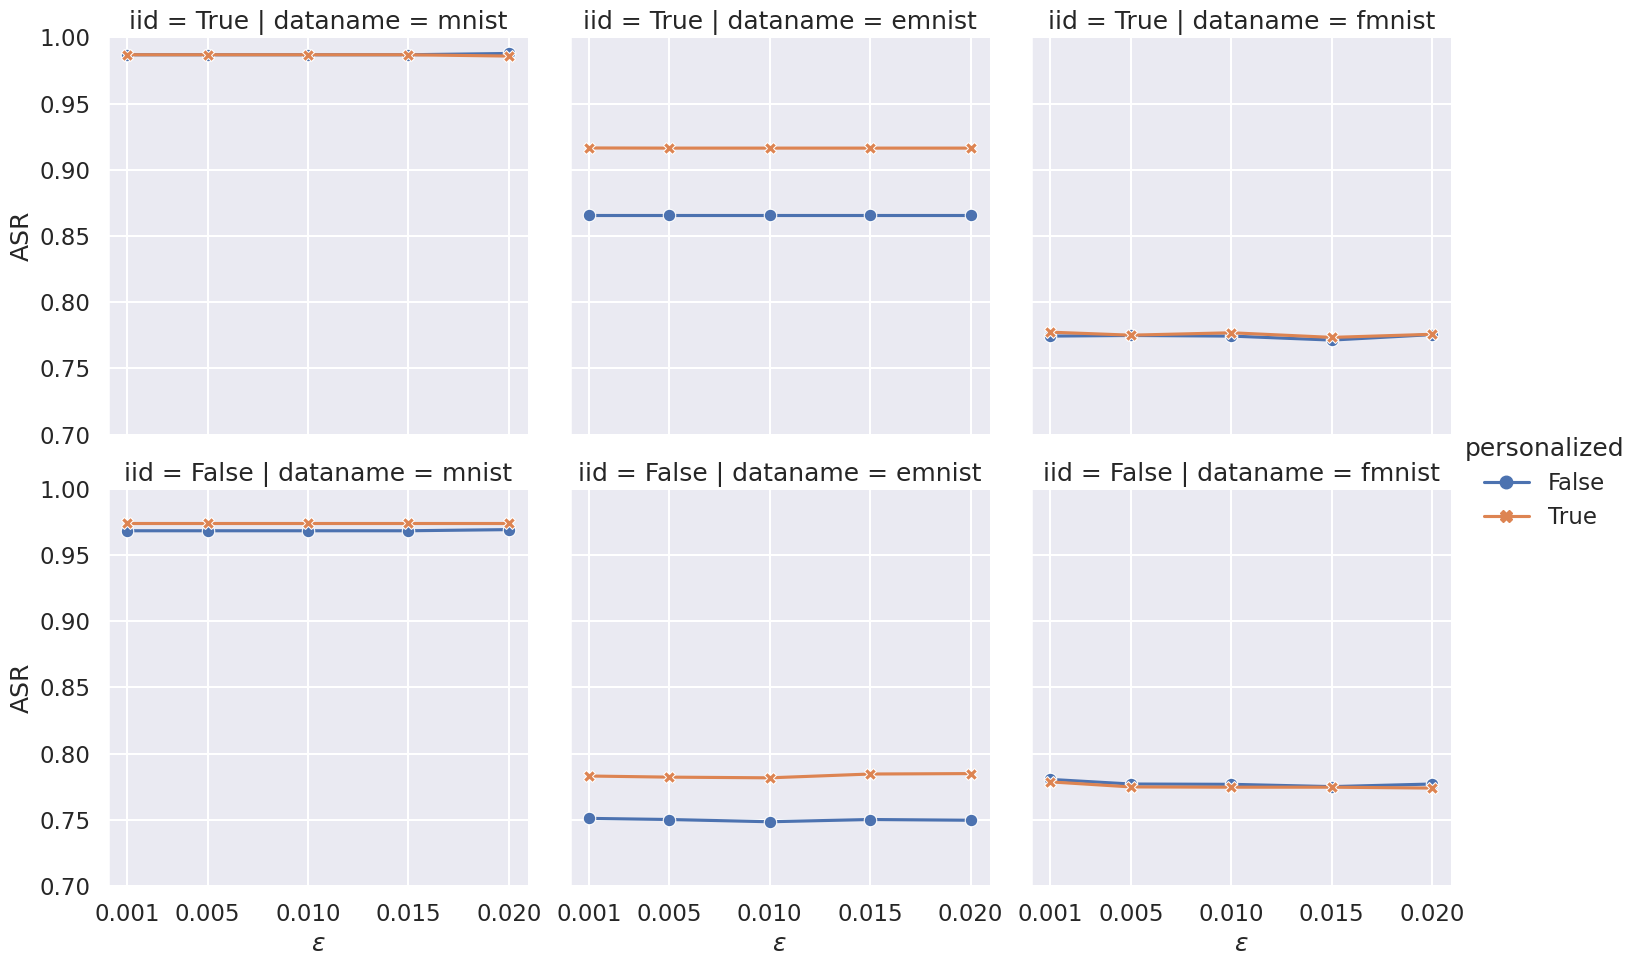

In [100]:
sns.set_theme(style='darkgrid')
sns.color_palette('colorblind')
sns.set_context('talk')
g = sns.relplot(data=df, kind='line',
            x='epsilon', y='asr', hue='personalized', style='personalized', col='dataname', row='iid',
            dashes=False, markers=True, row_order=[True, False])
plt.xticks([0.001, 0.005, 0.010, 0.015, 0.020])
plt.ylim([0.7, 1])
g.set_ylabels('ASR')
g.set_xlabels('$\epsilon$')

In [109]:
df.head()

,iid,dataname,epsilon,cad,asr,personalized
0,True,mnist,0.001,-23.32,0.986842,False
1,True,mnist,0.001,-23.21,0.986842,True
2,True,mnist,0.005,-23.32,0.986842,False
3,True,mnist,0.005,-23.21,0.986842,True
4,True,mnist,0.010,-23.32,0.986842,False


<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_7389/3200394854.py:6: SyntaxWarning: invalid escape sequence '\e'
  g.set_xlabels('$\epsilon$')


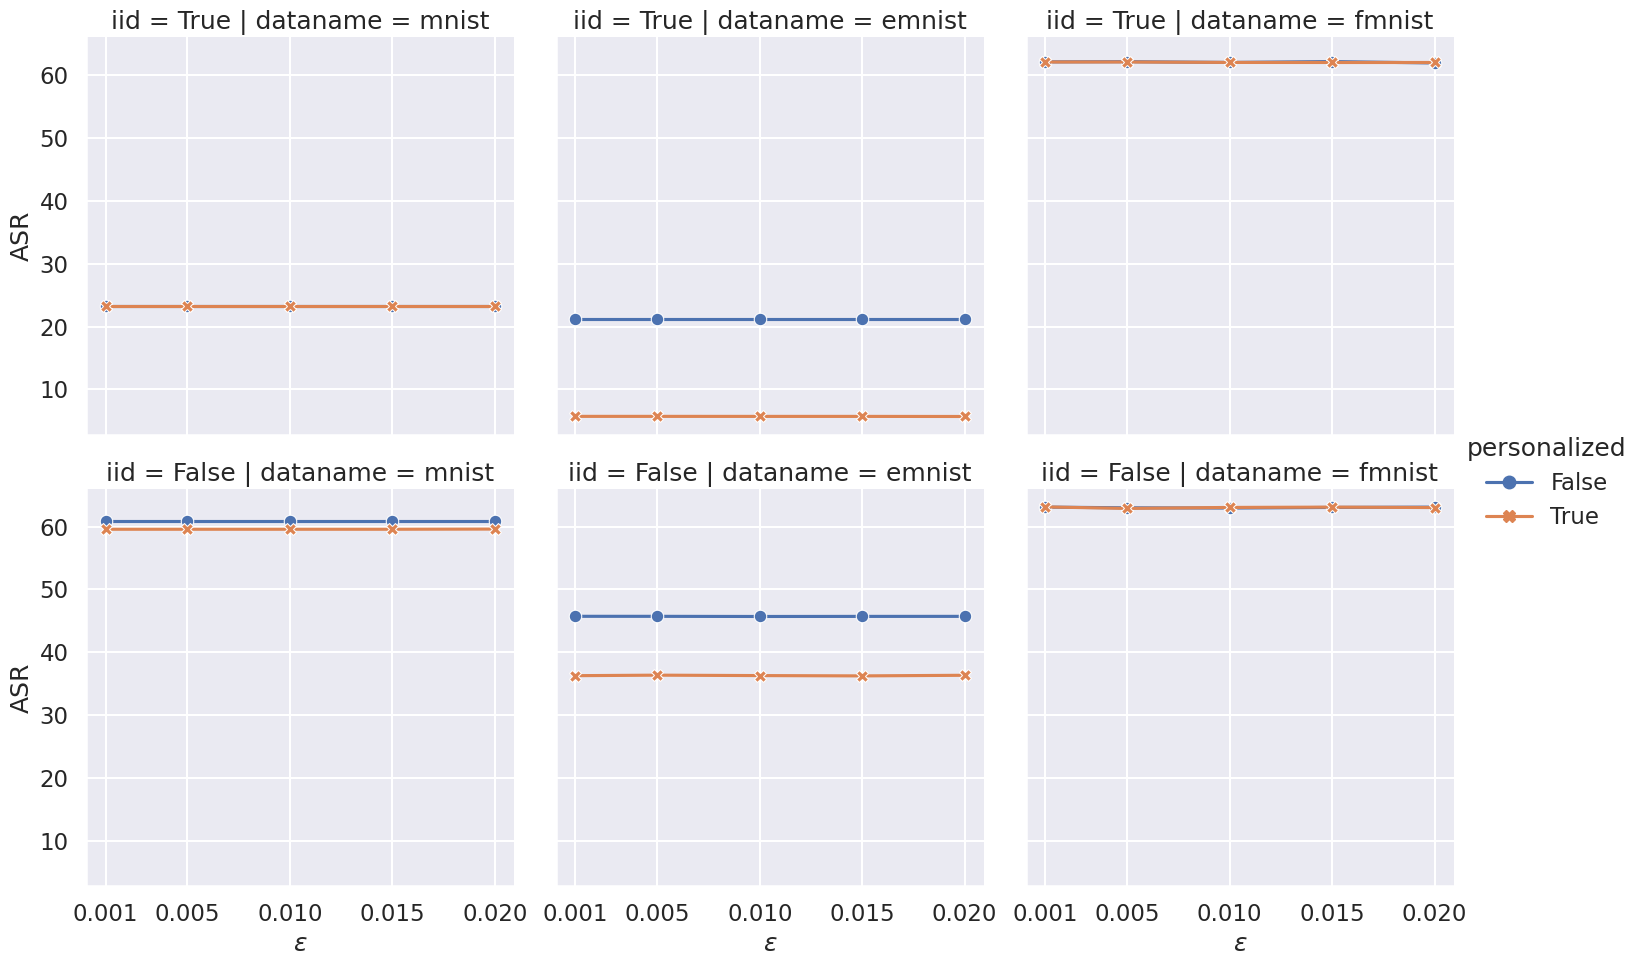

In [106]:
g = sns.relplot(data=df, kind='line',
            x='epsilon', y='cad', hue='personalized', style='personalized', col='dataname', row='iid',
            dashes=False, markers=True, row_order=[True, False])
plt.xticks([0.001, 0.005, 0.010, 0.015, 0.020])
g.set_ylabels('Accuracy Variation (%)')
g.set_xlabels('$\epsilon$')